<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLGameDrives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Install the library for NFL Data
!pip install nfl_data_py
import nfl_data_py as nfl

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import axes
import matplotlib.patches as patches
import numpy as np
from PIL import Image

from google.colab import drive

drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First Team: KC
Second Team: LAC
Year: 2022
2022 done.
Downcasting floats.
Those teams played twice that year. Choose Week 11(type 1) or Week 2(type 2): 2


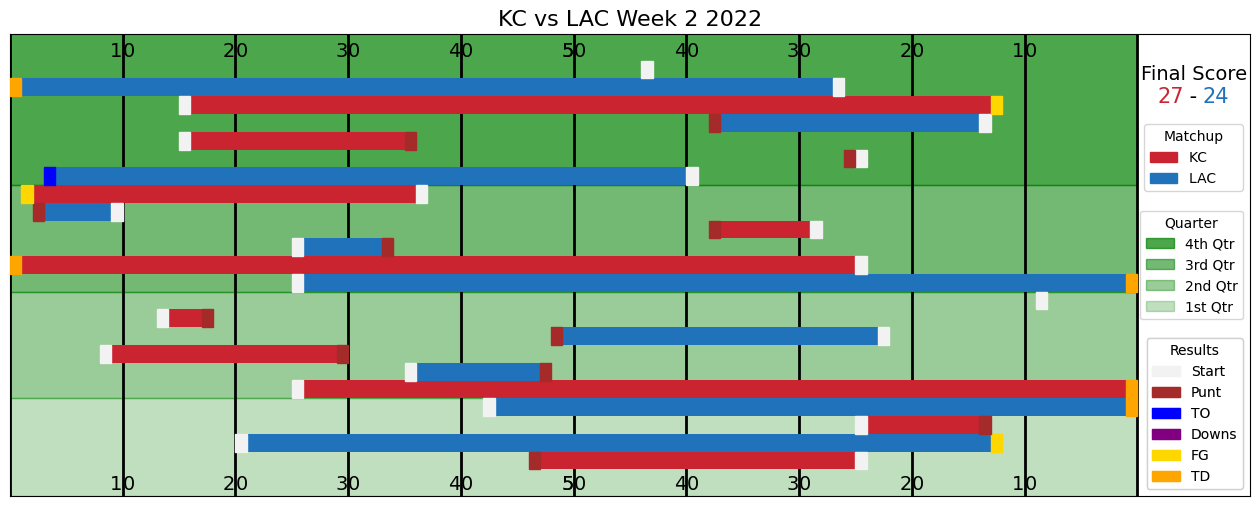

In [114]:
tm1 = input("First Team: ")
tm2 = input("Second Team: ")
year = input("Year: ")

years = int(year)

game_ids = []
rev_game_ids = []
for wk in range(1,19):
  if (wk < 10):
    game_ids.append(f"{year}_0{wk}_{tm1}_{tm2}")
    rev_game_ids.append(f"{year}_0{wk}_{tm2}_{tm1}")

  else:
    game_ids.append(f"{year}_{wk}_{tm1}_{tm2}")
    rev_game_ids.append(f"{year}_{wk}_{tm2}_{tm1}")


game = nfl.import_pbp_data([years])
game = game.loc[game.season_type=='REG']

pd.set_option('display.max_columns', None)
gm_stats = game[["game_id", "posteam","play_type", "drive", "qtr", "time", "yardline_100", "ydsnet", "drive_end_transition", "home_score", "away_score"]]

gm_stats.head()

actual_game = gm_stats[gm_stats["game_id"] == game_ids[0]]

div_count = 0;

for i in range(0, len(game_ids)):

  temp_game = gm_stats[gm_stats["game_id"] == game_ids[i]]
  if (len(temp_game) != 0):
    actual_game = temp_game
    wk = i+1

    div_count += 1
    div1_wk = i+1
    div1 = game_ids[i]

    home = tm2

  temp_game = gm_stats[gm_stats["game_id"] == rev_game_ids[i]]
  if (len(temp_game) != 0):
    actual_game = temp_game
    wk = i+1

    div_count += 1
    div2_wk = i+1
    div2 = rev_game_ids[i]

    home = tm1

if (div_count == 2):
  game_choice = input("Those teams played twice that year. Choose Week " + f"{div1_wk}" + "(type 1)" + " or Week " + f"{div2_wk}" + "(type 2): ")
  if (game_choice == "1"):
    actual_game = gm_stats[gm_stats["game_id"] == f"{div1}"]
    wk = div1_wk
    home = tm2
  if (game_choice == "2"):
    actual_game = gm_stats[gm_stats["game_id"] == f"{div2}"]
    wk = div2_wk
    home = tm1


actual_game = actual_game[actual_game['play_type'] != "kickoff"]
actual_game = actual_game[actual_game['play_type'] != "extra_point"]

actual_game = actual_game.sort_values(by = ["qtr","time"], ascending = [True, False]).reset_index(drop = True)

drive_start = actual_game.groupby('drive').first().reset_index()
drive_end = actual_game.groupby('drive').last().reset_index()

drive = pd.merge(drive_start, drive_end, on=['drive'])

drive = drive.rename(columns={'qtr_x': 'qtr',
  'posteam_x': 'posteam',
  'yardline_100_y': 'yardline_end',
  'yardline_100_x': 'yardline_start',
  'drive_end_transition_x': 'drive_result',
  'home_score_x' : 'home_score',
  'away_score_x' : 'away_score'})

drive_final = drive[["drive", "posteam", "qtr", "yardline_start", "yardline_end", "drive_result", "home_score", "away_score"]]

drive_final.loc[drive_final['drive_result'] == "TOUCHDOWN", ['yardline_end']] = 0

qtr_drive = drive_final.groupby('qtr').last().reset_index()

drive_final.head()


teamcolor = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

tm_colors = [teamcolor.get(team) for team in drive_final["posteam"]]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 6))

field_width = (len(drive_final["drive"])) * 4 - 4
field_length = 100

# Set the background color to green
if (len(qtr_drive["drive"]) == 5):
  ax.add_patch(patches.Rectangle((0, -8), 100, qtr_drive["drive"][0]*4+6, color="green", alpha=0.25, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][0]*4-2), 100, (qtr_drive["drive"][1]*4 - qtr_drive["drive"][0]*4), color="green", alpha=0.4, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][1]*4-2), 100, (qtr_drive["drive"][2]*4 - qtr_drive["drive"][1]*4), color="green", alpha=0.55, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][2]*4-2), 100, (qtr_drive["drive"][3]*4 - qtr_drive["drive"][2]*4), color="green", alpha=0.7, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][3]*4-2), 100, qtr_drive["drive"][4]*4+8, color="green", alpha=0.85, zorder=2))

else:
  ax.add_patch(patches.Rectangle((0, -8), 100, qtr_drive["drive"][0]*4+6, color="green", alpha=0.25, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][0]*4-2), 100, (qtr_drive["drive"][1]*4 - qtr_drive["drive"][0]*4), color="green", alpha=0.4, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][1]*4-2), 100, (qtr_drive["drive"][2]*4 - qtr_drive["drive"][1]*4), color="green", alpha=0.55, zorder=2))
  ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][2]*4-2), 100, qtr_drive["drive"][3]*4+8, color="green", alpha=0.7, zorder=2))

# Plot the field
plt.xlim(0, field_length + 10)
plt.ylim(-8, field_width + 8)

# Creates Bars
for i in range(len(drive_final["drive"])):

  if drive_final["qtr"][i] % 2 != 0:

    if (drive_final["posteam"][i] == tm1):
      plt.barh(4*i, drive_final["yardline_end"][i]  -  drive_final["yardline_start"][i], left=drive_final["yardline_start"][i], height=4, color=tm_colors[i], zorder = 10)

    if (drive_final["posteam"][i] == tm2):
      plt.barh(4*i, drive_final["yardline_start"][i] -  drive_final["yardline_end"][i], left=(100-drive_final["yardline_start"][i]), height=4, color=tm_colors[i], zorder = 10)

  if drive_final["qtr"][i] % 2 == 0:

    if (drive_final["posteam"][i] == tm1):
      plt.barh(4*i, drive_final["yardline_start"][i] -  drive_final["yardline_end"][i], left=(100-drive_final["yardline_start"][i]), height=4, color=tm_colors[i], zorder = 10)

    if (drive_final["posteam"][i] == tm2):
      plt.barh(4*i, drive_final["yardline_end"][i] -  drive_final["yardline_start"][i], left=drive_final["yardline_start"][i], height=4, color=tm_colors[i], zorder = 10)


# Start Lines
for i in range(len(drive_final["drive"])):
    bottom = 4 * i - 2

    if drive_final["qtr"][i] % 2 != 0:
        if (drive_final["posteam"][i] == tm1):
          plt.gca().add_patch(patches.Rectangle((drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

        if (drive_final["posteam"][i] == tm2):
          plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

    if drive_final["qtr"][i] % 2 == 0:

        if (drive_final["posteam"][i] == tm1):
          plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

        if (drive_final["posteam"][i] == tm2):
          plt.gca().add_patch(patches.Rectangle((drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

# Scoring
for i in range(len(drive_final["drive"])):
    bottom = 4 * i - 2

    if (drive_final["drive_result"][i] == "TOUCHDOWN"):
      if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((0, bottom), 1, 4, color="orange", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((99, bottom), 1, 4, color="orange", zorder = 25))

      if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((99, bottom), 1, 4, color="orange", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((0, bottom), 1, 4, color="orange", zorder = 25))

    if (drive_final["drive_result"][i] == "FIELD_GOAL"):
        if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

    if (drive_final["drive_result"][i] == "PUNT"):

        if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

    if (drive_final["drive_result"][i] in ["INTERCEPTION", "FUMBLE"]):

        if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

    if (drive_final["drive_result"][i] == "DOWNS"):

        if drive_final["qtr"][i] % 2 != 0:

          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((100 - drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == tm1):
            plt.gca().add_patch(patches.Rectangle((100 - drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

          if (drive_final["posteam"][i] == tm2):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

# Yard lines
for i in range(11):
  line =10 * i
  plt.axvline(line, color='k', linewidth = 2, zorder = 9)

# Yard lines Numbers
count = 1
for i in range(10, 51, 10):
  plt.text(i, -6.5, str(count), fontsize=14, color='k', ha='right')
  plt.text(100-i, -6.5, str(count), fontsize=14, color='k', ha='right')

  plt.text(i, field_width+3, str(count), fontsize=14, color='k', ha='right')
  plt.text(100-i, field_width+3, str(count), fontsize=14, color='k', ha='right')

  count += 1


for i in range(10, 100, 10):
  plt.text(i, -6.5, str(0), fontsize=14, color='k', ha='left')
  plt.text(i, field_width+3, str(0), fontsize=14, color='k', ha='left')


# Title
ax.set_title(tm1 + " vs " + tm2 + " Week " + str(wk) + " " + year, fontsize=16)

# LEGENDS
# Quarters
if (len(qtr_drive["drive"]) == 5):
  ot = patches.Patch(color='green', alpha = 0.85, label='OT Qtr')
  fourth = patches.Patch(color='green', alpha = 0.7, label='4th Qtr')
  third = patches.Patch(color='green', alpha = 0.55, label='3rd Qtr')
  second = patches.Patch(color='green', alpha = 0.4, label='2nd Qtr')
  first = patches.Patch(color='green', alpha = 0.25, label='1st Qtr')
  quarter = ax.legend(handles=[ot, fourth, third, second, first], loc='center right')
  quarter.set_title('Quarter')
  ax.add_artist(quarter)

else:
  fourth = patches.Patch(color='green', alpha = 0.7, label='4th Qtr')
  third = patches.Patch(color='green', alpha = 0.55, label='3rd Qtr')
  second = patches.Patch(color='green', alpha = 0.4, label='2nd Qtr')
  first = patches.Patch(color='green', alpha = 0.25, label='1st Qtr')
  quarter = ax.legend(handles=[fourth, third, second, first], loc='center right')
  quarter.set_title('Quarter')
  ax.add_artist(quarter)

# Matchup
team1_color = teamcolor.get(tm1)
team2_color = teamcolor.get(tm2)

team1 = patches.Patch(color=team1_color, label=f"{tm1}     ")
team2 = patches.Patch(color=team2_color, label=f"{tm2}     ")
matchup = ax.legend(handles=[team1, team2], bbox_to_anchor=(1, 0.82), loc='upper right')
matchup.set_title('Matchup')
ax.add_artist(matchup)

# Results
drive_start = patches.Patch(color='0.95', label='Start')
punt = patches.Patch(color='brown', label='Punt')
to = patches.Patch(color='b', label='TO')
to_on_downs = patches.Patch(color='purple', label='Downs')
field_goal = patches.Patch(color='gold', label='FG')
touchdown = patches.Patch(color='orange', label='TD')

markers = ax.legend(handles=[drive_start, punt, to, to_on_downs, field_goal, touchdown], loc='lower right')
markers.set_title('Results')
ax.add_artist(markers)

# Final Score
if (tm1 == home):
  plt.text(105, field_width - 1, "Final Score", fontsize=14, color="k", ha='center', va='center')
  plt.text(103, field_width - 6, str(drive_final["home_score"][0]), fontsize=15, color=team1_color, ha='center', va='center')
  plt.text(107, field_width - 6, str(drive_final["away_score"][0]), fontsize=15, color=team2_color, ha='center', va='center')
  plt.text(105, field_width - 6, " - ", fontsize=15, color="k", ha='center', va='center')

else:
  plt.text(105, field_width - 1, "Final Score", fontsize=14, color="k", ha='center', va='center')
  plt.text(103, field_width - 6, str(drive_final["away_score"][0]), fontsize=15, color=team1_color, ha='center', va='center')
  plt.text(107, field_width - 6, str(drive_final["home_score"][0]), fontsize=15, color=team2_color, ha='center', va='center')
  plt.text(105, field_width - 6, " - ", fontsize=15, color="k", ha='center', va='center')



# Remove x and y ticks
plt.xticks([])
plt.yticks([])


# Display the field
plt.show()